In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid'); sns.set_palette('dark')
import numpy as np
import pandas as pd
from pomegranate import *
from sklearn import mixture
from sklearn.linear_model import Ridge
numpy.random.seed(42)
numpy.set_printoptions(suppress=True)
from scipy.stats import rankdata
# from scipy.optimize import curve_fit
import math
import itertools
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error
# %load_ext watermark
# %watermark -m -n -p numpy,scipy,pomegranate

#Loading the dataset
df =  pd.read_csv('time_series.csv', encoding = 'utf8')

def date_conversion(date_string):
    datetime_object = datetime.strptime(date_string, '%d-%m-%Y')
    return datetime_object.date()

df['Date']= df.apply(lambda row: date_conversion(row.Date), axis = 1)

def get_first_day(df):
    return df.loc[0].Date
first_occurence = get_first_day(df)
def cumulative_day(Dates,first_occurence):
    val = (Dates-first_occurence).days + 1
    return val

# cum_day('China',first_occurence[0],first_occurence, country_list)
df['cum_day'] = df.apply(lambda row: cumulative_day(row.Date,first_occurence), axis = 1)
# df_new.insert(3, 'cum_day',cum_day)
threshold = 6
df['infected_t'] = df['Total Confirmed'] - df['Total Recovered'] - df['Total Deceased']
df_beta = df[df['Total Confirmed']<threshold]
df = df[df['Total Confirmed']>=threshold]
# print(df_beta.tail())


In [4]:
def cal_parameters(data):
    data['beta_t']=(-data['infected_t'].diff(periods=-1)  - data['Total Recovered'].diff(periods=-1)-
                    data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['beta_t']<0]['beta_t']=0
    data['gamma_t'] = (- data['Total Recovered'].diff(periods=-1))/((data['infected_t']))
    data[data['gamma_t']<0]['gamma_t']=0.0769
    data['mu_t'] = (- data['Total Deceased'].diff(periods=-1))/((data['infected_t']))
    data[data['mu_t']<0]['mu_t']=0
    return data


In [5]:
df= cal_parameters(df)
df_beta = cal_parameters(df_beta)

In [6]:
df.head()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased,cum_day,infected_t,beta_t,gamma_t,mu_t
33,2020-03-03,1,6,0,3,0,0,34,3,7.333333,-0.0,-0.0
34,2020-03-04,22,28,0,3,0,0,35,25,0.080000,-0.0,-0.0
35,2020-03-05,2,30,0,3,0,0,36,27,0.037037,-0.0,-0.0
36,2020-03-06,1,31,0,3,0,0,37,28,0.107143,-0.0,-0.0
37,2020-03-07,3,34,0,3,0,0,38,31,0.161290,-0.0,-0.0


In [7]:
med_gamma= df.gamma_t.median()
med_beta = df.beta_t.median()
med_mu = df.mu_t.median()

In [8]:
df['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
df_beta['beta_t'].replace([np.inf,-np.inf,np.nan],med_beta,inplace=True)
df_beta['gamma_t'].replace([np.inf,-np.inf,np.nan],med_gamma,inplace=True)
df_beta['mu_t'].replace([np.inf,-np.inf,np.nan],med_mu,inplace=True)
max_val_pred = len(df)

In [9]:
def FIR_filter(statistic,order,a):
    window = order +1
    slide = np.array([statistic[i:i+window] for i in range(len(statistic)-window+1)])
    training_x = slide[:,:-1]
    training_y = slide[:,-1]
    clf = Ridge(alpha = a)
    clf.fit(training_x,training_y)
    return clf

In [10]:
#start date should be greater than the first value in the dataframe. 
def sir_generator_backward(data,start_date,predict_range,window_size):
    start = date_conversion(start_date)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    clf_beta = FIR_filter(list(data.beta_t[:-2]),window_size,0.03)
    clf_gamma =  FIR_filter(list(data.gamma_t[:-2]),window_size,1e-6)
    clf_mu = FIR_filter(list(data.mu_t[:-2]),window_size,0.01)
    if (end <= last_existing_date):
        #data already exists.. to check accuracy of the model
        beta_pred = list(df_beta.beta_t[:-2])[-window_size:]
        bg_dates = list(df_beta.Date[:-2])[-window_size:]
        gamma_pred = list(df_beta.gamma_t[:-2])[-window_size:]
        mu_pred = list(df_beta.mu_t[:-2])[-window_size:]
        x_t_hat = []
        xr_dates = []
        r_t_hat = []
        d_t_hat = []
        val = []
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
#             print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            r_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Recovered'].item())+
                            (gamma_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            d_t_hat.append((data[data['Date']==bg_dates[-1]]['Total Deceased'].item())+
                            (mu_pred[-1])*(data[data['Date']==bg_dates[-1]].infected_t.item()))
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    else : 
        print('Out of Range')
        

In [11]:
#Should be 14 May,2020 or next date to where the data ends.
def sir_generator_forward(data,start_date,predict_range,window_size):
    start = date_conversion(start_date)
    end = start+timedelta(days=predict_range)
    last_existing_date = data.iloc[-1].Date
    clf_beta = FIR_filter(list(data.beta_t[:-2]),window_size,0.03)
    clf_gamma =  FIR_filter(list(data.gamma_t[:-2]),window_size,1e-6)
    clf_mu = FIR_filter(list(data.mu_t[:-2]),window_size,0.01)
    if (start > last_existing_date):
        #data already exists.. to check accuracy of the model
        beta_pred = list(data.beta_t[:-2])[-window_size:]
        bg_dates = list(data.Date[:-2])[-window_size:]
        gamma_pred = list(data.gamma_t[:-2])[-window_size:]
        mu_pred = list(data.mu_t[:-2])[-window_size:]
        x_t_hat = [list(data.infected_t)[-1]]
        xr_dates = [list(data.Date)[-1]]
#         print(type(x_t_hat))
        r_t_hat = [list(data['Total Recovered'])[-1]]
        d_t_hat = [list(data['Total Deceased'])[-1]]
        val = []
        for i in range(predict_range):
            bg_dates.append(start+timedelta(days=i-1))
            beta_pred.append(clf_beta.predict(np.array(beta_pred[-window_size:]).reshape(1,-1))[0])
            gamma_pred.append(clf_gamma.predict(np.array(gamma_pred[-window_size:]).reshape(1,-1))[0])
            mu_pred.append(clf_mu.predict(np.array(mu_pred[-window_size:]).reshape(1,-1))[0])
            xr_dates.append(start+timedelta(days=i))
#             print((len(data[data['Date']==bg_dates[-1]])))
            x_t_hat.append((1+beta_pred[-1]-gamma_pred[-1]-mu_pred[-1])*(x_t_hat[-1]))
            r_t_hat.append((r_t_hat[-1])+(gamma_pred[-1])*(x_t_hat[-1]))
            d_t_hat.append((d_t_hat[-1])+(mu_pred[-1])*(x_t_hat[-1]))
        
            val.append((1+beta_pred[-1]-gamma_pred[-1]))
        return (xr_dates,x_t_hat,r_t_hat,d_t_hat)
    else : 
        print('Please call SIR_Generator Backward function')
        

In [12]:
df_b_ldown = df[df['Total Confirmed']<=497].copy()
wl_d, wl_x,wl_r,wl_d = sir_generator_forward(df_b_ldown,'24-03-2020',30,14)
w_l_pred = pd.DataFrame(list(zip(wl_d,wl_x,wl_r,wl_d)), columns = ['Dates','Xt','Rt','Dt'])


In [13]:
a,b,c,d = sir_generator_backward(df,'04-03-2020',70,14)

In [14]:
e,f,g,h = sir_generator_forward(df,'14-05-2020',200,14)

In [15]:
trial =pd.DataFrame(list(zip(a,b,c,d)),columns=['Dates','Xt','Rt','Dt'])
trial_1 = pd.DataFrame(list(zip(e,f,g,h)),columns=['Dates','Xt','Rt','Dt'])
trial_2 = pd.concat([trial,trial_1],ignore_index=True)

70

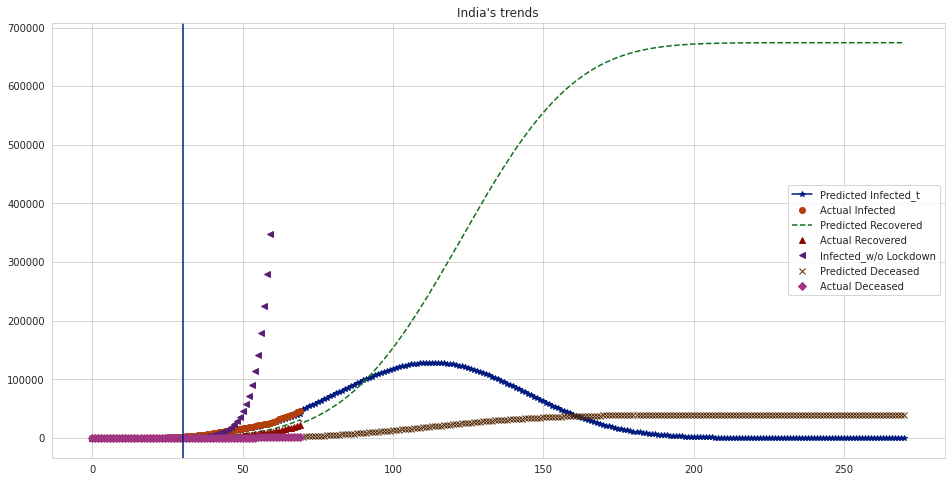

In [16]:
# trial = pd.DataFrame(a,columns=['Date','Infect'])
x_data = range(60)
plt.figure(figsize=(16,8))
line_1, = plt.plot(trial_2.Xt,marker = '*')
line_2, = plt.plot(list(df.iloc[:70].infected_t),'o')
line_3, = plt.plot(trial_2.Rt,'--')
line_4, = plt.plot(list(df.iloc[:70]['Total Recovered']),'^')
line_5, = plt.plot(x_data[30:],w_l_pred.iloc[1:].Xt,'<')
line_6, = plt.plot(trial_2.Dt,'x')
line_7, = plt.plot(list(df.iloc[:70]['Total Deceased']),'D')
plt.legend([line_1,line_2,line_3,line_4,line_5,line_6,line_7],
           ['Predicted Infected_t','Actual Infected','Predicted Recovered','Actual Recovered','Infected_w/o Lockdown',
           'Predicted Deceased','Actual Deceased'] )
plt.axvline(x=30)
plt.title("India's trends")
plt.savefig('pred_india.png')
# trial
len(list(df.iloc[2:79].infected_t))

In [17]:
trial_2.to_csv('Predicted_SIR.csv')